In [1]:
# Load packages
using SeisPlot, SeisProcessing, SeisMain, PyPlot, LinearAlgebra
using FFTW, Random, StatsBase, SparseArrays
include("../BFGD/fixSym1d.jl")
include("../BFGD/FreqInd.jl")

FreqInd (generic function with 1 method)

In [2]:
? SeisHypEvents

search: SeisHypEvents



SeisHypEvents(; <keyword arguments>)

Generate two dimensional data consisting of hyperbolic events.

# Arguments

  * `ot::Real=0.0`: first sample for the time axis in secs.
  * `dt::Real=0.004`: time sampling interval in secs.
  * `nt::Int=301`: number of time samples.
  * `ox::Real=-1000.0`: first sample for spatial dimension in meters.
  * `dx::Real=20.0`: sample interval for the spatial dimension in meters.
  * `nx::Int=101`: number of samples for the spatial dimension.
  * `tau::Vector{Real}=[0.2, 0.6, 0.9]`: intercept traveltimes for each event.
  * `vel::Vector{Real}=[1500.0, 2000.0, 3000.0]`: rms velocities in m/s
  * `apex::Vector{Real}=[0.0, 0.0, 0.0]`: apex-shifts in meters.
  * `amp::Vector{Real}=[1.0, -1.0, 1.0]`: amplitudes for each event.
  * `wavelet::AbstractString="ricker"`: wavelet used to model the events.
  * `f0::Vector{Real}=[20.0]`: central frequency of wavelet for each event.

# Output

  * `d::Array{Real, 2}`: two dimensional data consisting of hyperbolic events.

# Examples

```julia
julia> using SeisPlot
julia> d = SeisHypEvents(); SeisPlotTX(d);
julia> d = SeisHypEvents(apex=[100, 200, -300], f0=[30, 20, 15]);
SeisPlotTX(d);
```


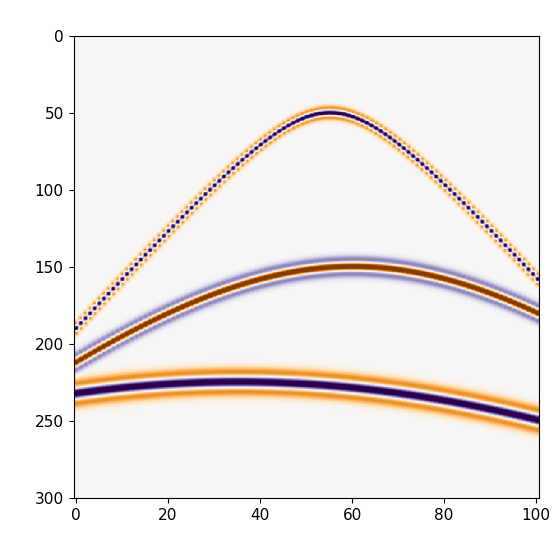

In [65]:
dh = SeisHypEvents(apex=[100, 200, -300], f0=[30, 20, 15]);
SeisPlotTX(dh);

In [73]:
function SeisDispEvents(;ot::Real=0.0,dt::Float64=0.004, nt::Int=301,
                         ox::Real=-1000.0, dx::Real=20.0,nx::Int=101,
                         vmin::Array{Float64}=[400.0;600.0], vmax::Array{Float64}=[900.0;900.0],
                         amp::Array{Float64}=1.2 .* [1,-1], fd::Array{Float64}=[10.0,20.0],
                         fmin::Float64=0.0, fmax::Float64=200.0, f0::Float64=12.0)
    
  
    # Prelim 
    x = ox .+ collect(Float64,0:1:nx-1)*dx
     nx = length(x);
nevents = length(vmin);
   nfft = 4*nextpow(2,nt);
    
    # Wavelet
    wav = Ricker(f0=f0, dt=dt);
     nw = length(wav);
    append!(wav,zeros(nfft-nw))
    Wav = fft(wav)
    
    # Allocate
    OUTF = zeros(Complex{Float64},nfft,nx)
     OUT = zeros(Float64,nfft,nx)
    
    # Freq range
    wrange = FreqInd((fmin,fmax),dt,nfft[1])
    
    # Imaginary unit
    im = complex(0,1)
    
    # Loop over (positive) freqs
    for iw in wrange
        f = (iw-1)/nfft/dt;
        w = 2*pi*f;
        
        Ac = zeros(Complex{Float64},nx,nevents)        
        for i in 1:nx, j in 1:nevents
                # TODO: Understand
                vc = vmin[j] + (vmax[j]-vmin[j]) ./ sqrt(1 .+ (f/fd[j])^4);
                 p = 1 ./ vc;
                 t = p*abs(x[i]);
            Ac[i,j]= exp(-im*w*t);
        end
        
        # Coefficients
        m = Wav[iw] .* amp;
        
        # Output
        OUTF[iw,:] = Ac*m;
    end
    
    # Symmetries and ifft
    OUTF = fixSym1d(OUTF,nfft);
     OUT = real( ifft(OUTF,1) );
   
    # Truncate
    OUT = OUT[1:nt,:]

    return OUT
    
end

SeisDispEvents (generic function with 1 method)

In [74]:
d = SeisDispEvents();

In [75]:
size(dh)

(301, 101)

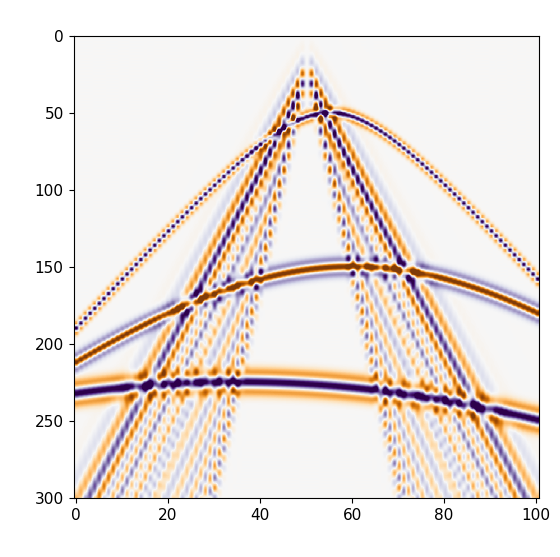

im

In [76]:
SeisPlotTX(d+dh)